# Testing Hypotheses On Medical Insurance Costs

## Introduction

In this project, I'm going to test four different hypotheses on medical expenses for US patients using a [Kaggle dataset]( https://www.kaggle.com/datasets/mirichoi0218/insurance) of medical insurance costs. If you're interested in a code-free version of the project, click [here](https://github.com/NicolaBagala/portfolio/blob/master/insurance/codefree/insurance_codefree.ipynb).

The four hypotheses are:
1. Average medical expenses are the same for male and female patients.
2. Average medical expenses are higher for people with higher BMI. (Body mass index; see below for more information.)
3. Smokers have higher average expenses than non-smokers.
4. Medical expenses grow with age.

**Note:** In this project, the terms "expenses", "expenditures", "costs", "charges", and variations thereof are all used in the same sense—medical costs billed by health insurance.

## Setup

This section contains imports, functions, and other code reused often throughout the project.

In [2]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np

Below are variables containing category colours used in different charts.

In [3]:
sex_colors = {
    "males": "royalblue",
    "females": "violet"
}

bmi_colors = {
    "normal": "forestgreen",
    "overweight": "darkorange",
    "obese": "red"
}

smoke_colors = {
    "smokers": "darkgoldenrod",
    "non-smokers": "green"    
}

Below are statistical functions I wrote for hypothesis testing and reporting.

In [4]:
def header_line(header):
    """
    Returns a dashed line the same length of an input string.
    
    header: input string.
    """
    return "-" * len(header)

def std_err(sample1, sample2):
    """
    Calculates and returns the standard error for the difference of two sample means.
    
    sample1, sample2: the samples from which the standard error must be calculated.
    """
    
    sample1_stdev = sample1.std()
    sample2_stdev = sample2.std()
    
    size1 = len(sample1) - 1
    size2 = len(sample2) - 1
    
    se = np.sqrt(((sample1_stdev**2)/size1) + ((sample2_stdev**2)/size2))
    return se                


def full_z_test(confidence, sample1, sample2, null):
    """
    Performs a z-test for the difference between two sample means, and prints out the results.
    
    confidence: confidence level for the test; takes values between 0 and 1.
    sample1, sample2: the two samples from which the means and their difference must be calculated
    null: the null value to compare the sample difference to
    """
    
    # Calculate p-value and confidence interval.    
    obs_diff = round(sample1.mean() - sample2.mean())
    se = std_err(sample1, sample2)
    z = round((obs_diff - null)/se, 4)
    
    # Calculate a two-tailed p-value.
    pos_zscore = abs(z)
    neg_zscore = - pos_zscore

    lower_tail = stats.norm.cdf(neg_zscore)
    upper_tail = 1 - stats.norm.cdf(pos_zscore)    
    pval = round(lower_tail + upper_tail, 4)
    
    # Confidence interval.
    cint = stats.norm.interval(confidence, loc = obs_diff, scale = se)
    cint = (round(cint[0], 4), round(cint[1], 4))
    
    # Report test results.
    header = "Z-test summary"
    
    z_msg = "Z-score of observed value {}: {}".format(obs_diff, z)
    p_msg = "Probability of observing value {} if the null value is {} (p-value): {}".format(obs_diff, null, pval)
    cint_msg = "{}% confidence interval: {}".format(confidence * 100, cint)
    
    print(header, header_line(header), z_msg, p_msg, cint_msg, sep = "\n")

def full_t_test(confidence, sample1, sample2, null):
    """
    Performs a t-test for the difference between two sample means, and prints out the results.
    
    confidence: confidence level for the test; takes values between 0 and 1.
    sample1, sample2: the two samples from which the means and their difference must be calculated
    null: the null value to compare the sample difference to
    """
    
    # Calculate p-value and confidence intervals.
    t_res = stats.ttest_ind(sample1, sample2, equal_var = False)
    
    t = round(t_res[0], 4)
    pval = round(t_res[1], 4)
    
    obs_diff = round(sample1.mean() - sample2.mean())
    se = std_err(sample1, sample2)
    df = len(sample1) + len(sample2) - 2 # In this case, we always only have one parameter to calculate from each sample, so the df are always total observations - 2.
    
    cint = stats.t.interval(confidence, df = df, loc = obs_diff, scale = se)
    cint = (round(cint[0], 4), round(cint[1], 4))
    
    # Report test results.
    header = "T-test summary"

    t_msg = "T-score of observed value {}: {}".format(obs_diff, t)
    p_msg = "Probability of observing value {} if the null value is {} (p-value): {}".format(obs_diff, null, pval)
    cint_msg = "{}% confidence interval: {}".format(confidence *100, cint)

    print(header, header_line(header), t_msg, p_msg, cint_msg, sep = "\n")
    
def cohend(sample1, sample2):
    """
    Calculates and returns Cohen's d, a measure of the practical significance of an observed difference wrt data variability.
    
    sample1, sample2: the samples from which averages, their difference, and Cohen's d must be calculated.
    """    
    
    s1 = sample1.std()
    n1 = len(sample1)   
    
    s2 = sample2.std()
    n2 = len(sample2)   
    
    num = (n1 - 1) * s1 ** 2 + (n2 - 1) * s2 ** 2
    den = n1 + n2 - 2
    
    pooled_sd = np.sqrt(num/den)
    
    d = (sample1.mean() - sample2.mean())/pooled_sd
    
    return d    

Finally, here are plotting functions written to allow to create standardised charts quickly.

In [23]:
def format_axes(ax):    
    """
    Sets the style of an axes' x and y labels.
    
    ax: the Matplotlib axes whose axis labels style must be set.
    """
    
    ax.set_xlabel("", fontweight = "bold", fontsize = "large")
    ax.set_ylabel("", fontweight = "bold", fontsize = "large")    

def kde_plot(datasets, ax, colors, labels, xlabel):
    """
    Creates and displays a kernel density estimate plot for the given data sets.
    
    datasets: a list of data sets whose kde plots must be generated
    ax: the axes onto which the kde plots must be plotted
    colors: the colors of each kde plot
    labels: data label for each kde plot
    xlabel: the x-axis label of ax (The y-label is generated automatically by plot.kde)    
    """
        
    format_axes(ax)
    
    for data, label in zip(datasets, labels):
        data.plot.kde(ax = ax, color = colors[label.lower()], label = "{} ({})".format(label, len(data)))
        ax.axvline(x = data.mean(), color = colors[label.lower()], ls = "--")
        
    # 'Phantom' average for legend (invisible average line which will be displayed in the legend to indicate every average line on the chart)
    ax.axvline(x = datasets[0].mean(), color = "black", label = "Averages", ls = "--", zorder = 1)
    ax.set_xlabel(xlabel)
    ax.legend();                
    
def box_plot(data, ax, labels, xlabel, ylabel):
    """
    Creates and displays a box plot of the given data.
    
    data: array or sequence of vectors containing the data to plot
    ax: Matplotlib axes on which to plot the data
    labels: the labels for each data set in data
    xlabel, ylabel: the x- and y-axis labels of the chart    
    """    
    
    format_axes(ax)
    
    bp = ax.boxplot(x = data, labels = labels, showmeans = True) 
    ax.legend([bp["medians"][0], bp["means"][0]], ["medians", "means"])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);    
    
def plot_cohend(d):
    """
    Creates a plot to display Cohen's d in relation to effect size.
    
    d: the value of Cohen's d.
    """
    
    # We are not interested in the direction of d. Only the magnitude.
    abs_d = abs(d)

    fig, ax = plt.subplots(1, 1, figsize = (10, 1), facecolor ="white")
    
    format_axes(ax)
    
    # The scale of d values and d itself are multiplied by ten to make the chart pretty. The value of d is displayed correctly, though.
    scaled_d = abs_d * 10
    
    # Place scaled_d on the axes.
    ax.axvline(scaled_d, color = "red", linewidth = 2)
    
    # Annotate the correct value of Cohen's d on the axes.
    note = ax.annotate(round(abs_d, 4), (scaled_d + 0.25, 0.82), fontweight = "bold", color = "red", fontsize = "large")    
    note.set_path_effects([path_effects.Stroke(linewidth=3, foreground = "black"), path_effects.Normal()])
    
    ax.set_yticks([])
    # Below, the actual numerical values correspondng to Very small, Small, etc, are 0.01, 0.2, 0.5, 0.8, 1.2, and 2. They have been multiplied by 10
    # to make the chart look a decent size.
    ax.set_xticks([0.1, 2, 5, 8, 12, 20] , ["Very \nsmall", "Small", "Medium", "Large", "Very large", "Huge"])
    ax.tick_params(axis = "x", labelleft = True, labelbottom = True)
    
    # Limits of the x-axis.
    x_low = 0
    # Depending on how big scaled_d is, we might need a longer x-axis. (At least the size of scaled_d plus some arbitrary wiggle room.)
    x_high = 20 if scaled_d < 20 else scaled_d + 2 
    
    # Draw a gradient colormap on the background.
    background_array = np.arange(x_low, x_high, 0.01)
    background_array = np.vstack((-background_array, )) # This orients the array correctly, and makes the colormap display so that yellow is first and purple is last.
    ax.imshow(background_array, cmap=plt.cm.viridis, extent = (x_low, x_high, 0, 2))
    
    ax.set_xlim(x_low, x_high)       
    ax.set_ylim(0, 2)
    ax.set_xlabel("Effect size (Cohen's d)")

## The dataset

According to the original source, the dataset is a simulated dataset created for the book *Machine Learning with R* by Brett Lantz. The book itself states that it is

> a simulated dataset containing medical expenses
for patients in the United States. These data were created for this book using
demographic statistics from the U.S. Census Bureau, and thus approximately
reflect real-world conditions.

That said, the dataset is good enough for the scope of this project, so let's familiarise with it.

In [6]:
insurance = pd.read_csv("insurance.csv")
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset contains seven columns and 1338 rows, with no nulls. Let's see what each column represents.

- `age`: age of the insurance contractor's primary beneficiary
- `sex`: sex of the insurance contractor, female or male
- `bmi`: [Body mass index](https://en.wikipedia.org/wiki/Body_mass_index), a general indicator of body fitness
- `children`: number of children covered by health insurance
- `smoker`: whether the insurance contractor is a smoker, yes or no
- `region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest
- `charges`: individual medical costs billed by health insurance for one calendar year.

There's not much cleaning to be done, except turning the column `smoker` from `string` (yes\no) to `bool` (`True`\ `False`).

In [7]:
# Turn `smoker` field into boolean.
insurance["smoker"] = insurance["smoker"].map(lambda x: 1 if x == "yes" else 0).astype(bool)

## Hypothesis 1: Average medical expenditures are the same for males and females

The starting hypothesis is that the patient's sex doesn't significantly affect the magnitude of his or her medical expenses. That is, on average, male patients will have the same expenditures as female patients. The alternative hypothesis is that these two averages will be different. Let's compute these averages and their difference for the observations in the dataset.

In [8]:
male_costs = insurance.query("sex == 'male'")["charges"]
female_costs = insurance.query("sex == 'female'")["charges"]

male_avg_cost = round(male_costs.mean())
female_avg_cost = round(female_costs.mean())
mf_diff = male_avg_cost - female_avg_cost

print("Male average cost: {}".format(male_avg_cost))
print("Female average cost: {}".format(female_avg_cost))
print("Difference (male - female): {}".format(mf_diff))

Male average cost: 13957
Female average cost: 12570
Difference (male - female): 1387


**On average, male insurance costs are $1387 higher than female costs.** Is this consistent with the hypothesis that the two costs are the same at the population level? In other words, **is the difference in the sample due to chance, or does it reflect a difference at the population level?** Let's explore the samples.

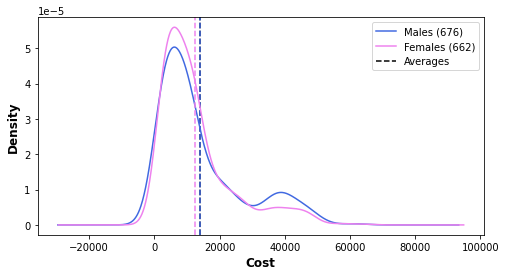

In [20]:
fig_costs_bysex, ax_costs = plt.subplots(1, 1, figsize = (8, 4), facecolor ="white")
kde_plot(datasets = [male_costs, female_costs], ax = ax_costs, colors = sex_colors, labels = ["Males", "Females"], xlabel = "Cost")

*`Figure 1. Distribution of male (blue) and female (purple) medical expenditures.`*

The chart shows the fraction of medical expenditures that fall within a certain range. (This means that the area under each curve is 1, i.e. the whole "fraction" of medical expenditures for each sex.) We see that both expenditure distributions are right-skewed, with a larger fraction of costs falling between 0 and about 20.000 USD, and a smaller fraction of higher costs. More importantly for the project's purposes, **both distributions are very close to each other and likely not significantly different.** 

We're going to see in a moment whether the difference between the average expenditures for males and females, $1387, is statistically significant or not; however, its *practical* significance is debatable. According to Cohen's *d*, the difference is rather small.

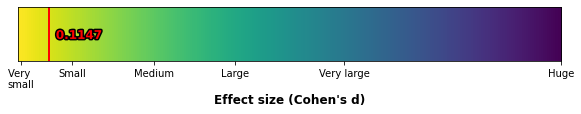

In [24]:
d = cohend(male_costs, female_costs)
plot_cohend(d)

*`Figure 2. Cohen's d for male and female average medical expenditures. The low value indicates that the two expenditure distributions largely overlap.`*

A low *d* value means that the observed difference is small in relation to the variability of the data. In other words, a low *d* means that the two distributions being compared have a lot of overlap, which is certainly true in our case. Still, an insurance company would probably like to keep in mind that male patients are more "expensive".

Let's now see whether the observed difference between male and female expenditures is statistically significant or not. Given the large sample sizes, the sampling distribution of the average male and female costs is likely normal, but here and in the following, I'm going to test all hypotheses using both the z-test and the t-test, for the sake of comparison.
 
The starting hypothesis is that, at the population level, average male and female costs are the same, i.e. their difference is zero; what needs checking is if the difference observed in the sample is consistent with this hypothesis or not.

In [11]:
full_z_test(0.95, male_costs, female_costs, 0)
print("\n")
full_t_test(0.95, male_costs, female_costs, 0)

Z-test summary
--------------
Z-score of observed value 1387: 2.0991
Probability of observing value 1387 if the null value is 0 (p-value): 0.0358
95.0% confidence interval: (91.9098, 2682.0902)


T-test summary
--------------
T-score of observed value 1387: 2.1009
Probability of observing value 1387 if the null value is 0 (p-value): 0.0358
95.0% confidence interval: (90.7354, 2683.2646)


According to the z-test, the starting hypothesis can be rejected at a 95% confidence level, because the probability of observing a difference between male and female expenditures of $1387 in the sample if there was no difference at the population level is smaller than 5%. In other words, despite the appearances, **the difference observed in the sample is significant, and it suggests that male and female average costs are different at the population level as well.** The confidence interval—the range of possible values for this difference—is rather large, meaning that the average medical expenses for males could be anywhere between about 92 and 2682 dollars higher than for females. Regardless of the exact amount, the data strongly suggests that average medical costs for males are higher than for females. (Remember that the difference between the two averages was calculated as `male cost - female cost`.) The results of the t-test are very similar, and further confirm the results of the z-test.

## Hypothesis 2: Average medical expenditures correlate with higher BMI values

Adults are classified according to [body mass index](https://en.wikipedia.org/wiki/Body_mass_index) as follows:
- BMI less than 18.5: underweight
- BMI between 18.5 and 24.9: normal weight
- BMI between 25 and 29.9: overweight
- BMI 30 or above: obese

As being overweight or obese typically comes with compounded health problems, it's reasonable to expect higher medical expenses for individuals with higher BMI. Let's check that with a scatter plot.

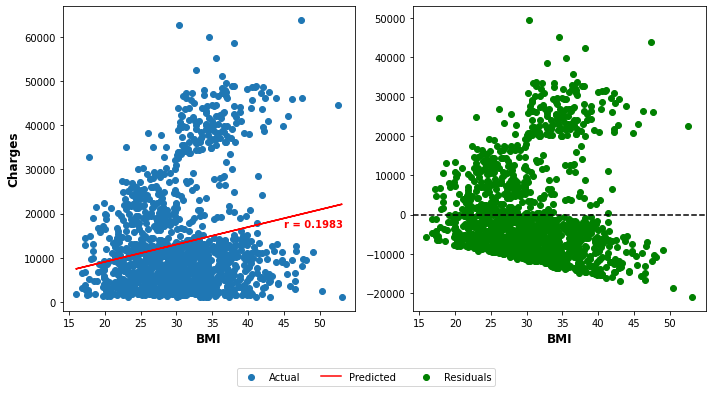

In [21]:
fig_bmi_cost, (ax_bmi_cost_scatter, ax_bmi_cost_residuals) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, facecolor ="white")

format_axes(ax_bmi_cost_scatter)
format_axes(ax_bmi_cost_residuals)

# Plot the data.
ax_bmi_cost_scatter.scatter(insurance["bmi"], insurance["charges"], label = "Actual")
ax_bmi_cost_scatter.set_xlabel("BMI")
ax_bmi_cost_scatter.set_ylabel("Charges")

# Add linear regression to the scatterplot.
lin_reg = stats.linregress(insurance["bmi"], insurance["charges"])
fitted_line_charges = lin_reg.intercept + lin_reg.slope * insurance["bmi"]
residuals = insurance["charges"] - fitted_line_charges

ax_bmi_cost_scatter.plot(insurance["bmi"], fitted_line_charges, color = "red", label = "Predicted")
ax_bmi_cost_scatter.annotate("r = {}".format(round(lin_reg.rvalue, 4)), (45, 17000), color = "red", fontweight = "bold")

ax_bmi_cost_residuals.scatter(insurance["bmi"], residuals, color = "green", label = "Residuals")
ax_bmi_cost_residuals.set_xlabel("BMI")
ax_bmi_cost_residuals.axhline(0, color = "black", ls = "--")
fig_bmi_cost.legend(bbox_to_anchor= (0.7, -0.02), ncol = 3);
fig_bmi_cost.tight_layout();

*`Figure 3. On the left, medical expenditures are plotted against BMI; a linear model has been fitted to the data. On the right, the chart shows the difference between the observed expenditures and the linear model prediction.`*

The charts shows the data, a linear model fitted to it, and the residual difference between observed data and the linear model. The low value of the correlation coefficient *r*, the residuals scattered all over the place, often far from zero, and the low percentage of variance in the charges explained by the BMI ($r^2$, equal to about 4%), show that a linear model is a very poor fit for the data. (Which is also quite apparent at a glance, to be fair.) What the scatter plot seems to show is that **the bulk of medical expenses clusters mostly below 10.000 USD, regardless of BMI, but any exceptions and outliers tend to be higher for higher BMIs.**

Regardless, there's definitely a clear uptick as BMI goes up, which can be seeen more clearly by grouping the data based on BMI values.

In [13]:
def group_by_bmi_range(idx, df):
    """Returns the weight status of a given insurance contractor in the dataset.
    
    idx: DataFrame index identifying a contractor.
    df: DataFrame containing the contractor data.    
    """
    
    # Contractor BMI.
    bmi = df.loc[idx, "bmi"]
    
    if bmi < 18.5: return "Underweight"
    if 18.5 <= bmi < 25: return "Normal"
    if 25 <= bmi < 30: return "Overweight"
    return "Obese"

# Group contractors by their weight status (underweight, normal, overweight, or obese) and calculate both the group size and average insurance charge for each group.
charges_by_bmi_range = insurance.groupby(by = lambda idx: group_by_bmi_range(idx, insurance))["charges"]
charges_and_range_size_table = pd.DataFrame({"Mean charges": round(charges_by_bmi_range.mean()), "Range size": charges_by_bmi_range.size()})
charges_and_range_size_table.sort_values(by = "Mean charges", ascending = False)

,Mean charges,Range size
Obese,15552.0,707
Overweight,10988.0,386
Normal,10409.0,225
Underweight,8852.0,20


*`Table 1. Mean charges (medical expenditures) for people in each BMI range. The number of people in the range is also reported for context.`*

The average charge does indeed grow with weight status (or equivalently, with BMI), and so does the size of the set of people within the given BMI range. (As it is probably to be expected in random sample of Americans...) Forgetting the `underweight` group, which is too small to reliably infer anything out of it, let's plot the distribution of the other three groups, and then try to see if the difference between the observed averages reflect a difference at the population level or is due to random chance.

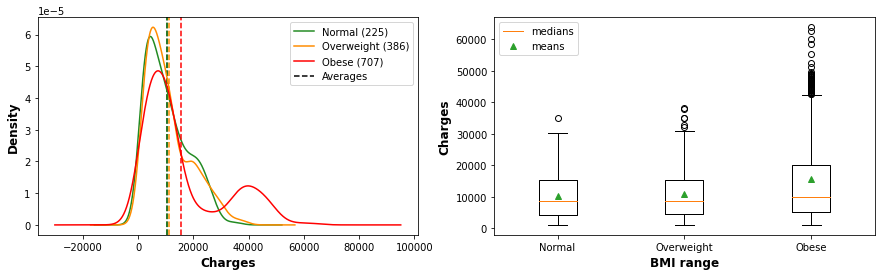

In [22]:
# BMI range shorthands.
norm_bmi = charges_by_bmi_range.get_group("Normal")
over_bmi = charges_by_bmi_range.get_group("Overweight")
obese_bmi = charges_by_bmi_range.get_group("Obese")

ranges_of_interest = ["Normal", "Overweight", "Obese"]
charges_by_bmi_range_as_list = [norm_bmi, over_bmi, obese_bmi]

fig_charges_by_bmi, (ax_charges_by_bmi_kde, ax_charges_by_bmi_box) = plt.subplots(1, 2, figsize = (15, 4), facecolor ="white")

kde_plot(datasets = charges_by_bmi_range_as_list, ax = ax_charges_by_bmi_kde, colors = bmi_colors, labels = ranges_of_interest, xlabel = "Charges")
box_plot(charges_by_bmi_range_as_list, ax_charges_by_bmi_box, ranges_of_interest, "BMI range", "Charges")

*`Figure 4. On the left, distribution of medical expenditures for normal, overweight, and obese people. On the right, a box plot shows the three distributions and any outliers separately.`*

The average cost is quite a bit higher for obese people than for normal or overweight people; the distributions of the latter two ranges are very similar, with just a few outliers for the overweight people. The distribution of charges for obese people is more spread out, with several outliers that account for the "bump" of the red line on the left-hand side chart. 

There are two hypotheses to test; the first is that, at the population level, the average insurance charges of normal-weight people are the same as that of overweight people. The alternative hypothesis is that the two averages are different.

In [15]:
full_z_test(0.95, norm_bmi, over_bmi, 0)
print("\n")
full_t_test(0.95, norm_bmi, over_bmi, 0)

Z-test summary
--------------
Z-score of observed value -578: -0.8925
Probability of observing value -578 if the null value is 0 (p-value): 0.3721
95.0% confidence interval: (-1847.245, 691.245)


T-test summary
--------------
T-score of observed value -578: -0.8945
Probability of observing value -578 if the null value is 0 (p-value): 0.3715
95.0% confidence interval: (-1849.7725, 693.7725)


Once again, both tests yield very similar results. In the sample, normal-weight people have medical expenses that are, on average, $578 cheaper than for overweight people. Both tests say that there's about a 37% chance of observing a difference of this magnitude in the sample even if the same difference at the population level was zero. This means that **the hypothesis that normal-weight and overweight people have on average the same medical expenditures can't be ruled out.**

The practical significance of this difference, as measured by Cohen's *d*, is again rather small, reflecting the significant overlap between the green and yellow distributions in `Figure 4`. (Still, one could argue that there's no such thing as an insignificant dollar spent on health care.)

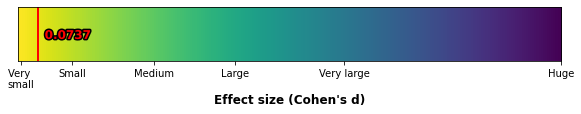

In [26]:
d = cohend(norm_bmi, over_bmi)
plot_cohend(d)

*`Figure 5. Cohen's d for the difference between normal-weight and overweight people's medical expenditures. The value is very low, so there is very significant overlap between the two distributions.`*

The second hypothesis to test is that the average insurance charges for normal-weight and obese people are the same at the population level. Again, the alternative hypothesis is that they are different.

In [17]:
full_z_test(0.95, norm_bmi, obese_bmi, 0)
print("\n")
full_t_test(0.95, norm_bmi, obese_bmi, 0)

Z-test summary
--------------
Z-score of observed value -5143: -6.9257
Probability of observing value -5143 if the null value is 0 (p-value): 0.0
95.0% confidence interval: (-6598.4597, -3687.5403)


T-test summary
--------------
T-score of observed value -5143: -6.9354
Probability of observing value -5143 if the null value is 0 (p-value): 0.0
95.0% confidence interval: (-6600.3564, -3685.6436)


**Both tests reject the hypothesis as virtually impossible:** in the sample, the medical expenditures of normal-weight people are on average $5143 cheaper than for obese people, and **the probability of observing such a difference in the sample if there was no difference in the population is zero.** Both confidence intervals lie comfortably to the left of zero, suggesting that, indeed, medical expenses for normal-weight people are on average lower than for obese people. The observed difference is statistically very significant, although according to Cohen's *d* its practical significance is small-to-medium; the overlap between the expenditure distribution of normal-weight and obese people is quite a bit smaller than in previous cases, but it's still there.

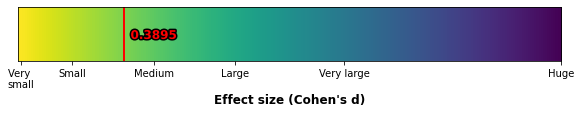

In [25]:
d = cohend(norm_bmi, obese_bmi)
plot_cohend(d)

*`Figure 6. Cohen's d for the difference between the average medical expenditures of normal-weight and obese people. This value indicates a smaller overlap between the two distributions than we've seen so far.`*

## Hypothesis 3: Average medical expenditures of smokers are higher than those of non-smokers

The third hypothesis to test is whether smokers have higher average medical expenses than non-smokers. Let's start by checking these values in the sample and plotting the two distributions.

In [19]:
smokers = insurance.query("smoker == True")["charges"]
non_smokers = insurance.query("smoker == False")["charges"]

print("Smokers: average charge {}, sample size {}".format(round(smokers.mean()), len(smokers)))
print("Non-smokers: average charge {}, sample size {}".format(round(non_smokers.mean()), len(non_smokers)))

Smokers: average charge 32050, sample size 274
Non-smokers: average charge 8434, sample size 1064


The difference in sample size is not small, but the average charge of smokers is almost 4 times larger than for non-smokers, suggesting that they may in general have higher medical expenditures.

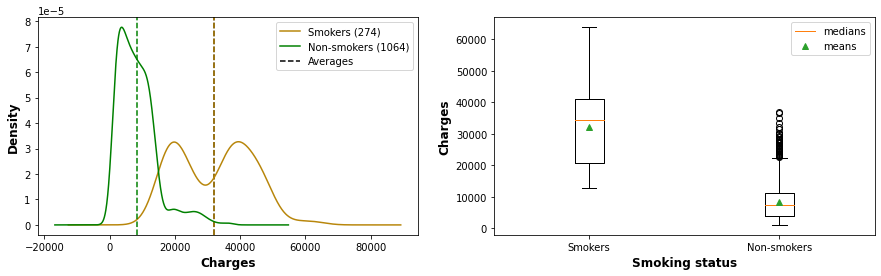

In [27]:
fig_smokers, (ax_smokers_kde, ax_smokers_box) = plt.subplots(1, 2, figsize = (15, 4), facecolor ="white")

kde_plot(datasets = [smokers, non_smokers], ax = ax_smokers_kde, colors = smoke_colors, labels = ["Smokers", "Non-smokers"], xlabel = "Charges")
box_plot([smokers, non_smokers], ax = ax_smokers_box, labels = ["Smokers", "Non-smokers"], xlabel = "Smoking status", ylabel = "Charges")

*`Figure 7. Distribution of medical expenditures for smokers and non-smokers. In both charts, the two distributions have visibly little overlap.`*

The charts leave little doubt that **smokers in the sample have much higher medical expenditures, both in general and on average.** Their expenditure range is larger, with the top 25% expenditures reaching as far as over $60.000. Also notice the absence of outliers amongst smokers: high expenditures are common in this group, unlike for the non-smoker group, where very high expenses are exceptional, infrequent, and *almost entirely below the average health expenses of smokers!*

Let's now assess the statistical significance of this difference. As usual, the starting assumption is that, at the population level, there is no difference between the average medical expenditure of the two groups.

In [21]:
full_z_test(0.95, smokers, non_smokers, 0)
print("\n")
full_t_test(0.95, smokers, non_smokers, 0)

Z-test summary
--------------
Z-score of observed value 23616: 32.695
Probability of observing value 23616 if the null value is 0 (p-value): 0.0
95.0% confidence interval: (22200.2938, 25031.7062)


T-test summary
--------------
T-score of observed value 23616: 32.7519
Probability of observing value 23616 if the null value is 0 (p-value): 0.0
95.0% confidence interval: (22199.0101, 25032.9899)


The difference between smokers and non-smokers is 23616 USD—that is, an average smoker's medical expenditures are well over $20.000 higher than those of an average non-smoker. Both tests say the same thing—**the probability of observing such a difference in the sample, if there was no difference in the population, is basically zero.** The confidence intervals are also fairly narrow, suggesting that the observed sample difference of 23616 dollars  is a pretty good estimate of the difference between smoker and non-smoker average medical expenses in the population. Cohen's *d* is also very large, highlighting the small overlap between the two distributions.

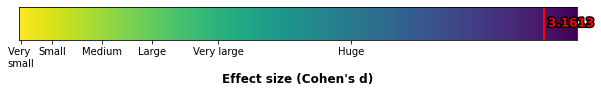

In [28]:
d = cohend(smokers, non_smokers)
plot_cohend(d)

*`Figure 8. The value of Cohen's d in the case of smokers and non-smokers is extremely large. A good part of the overlap between the two distributions is due to outliers amongst non-smokers!`*

## Hypothesis 4: Expenditures grow with age

As health deteriorates with age, it's reasonable to expect that health care costs will go up with age. This is certainly true for the sample, as it can be seen below.

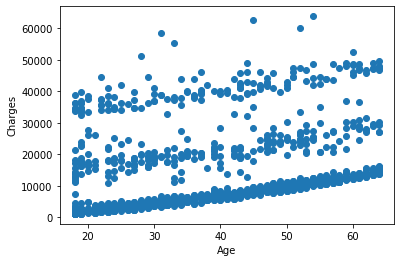

In [30]:
plt.figure(facecolor = "white")
plt.scatter(insurance["age"], insurance["charges"])
plt.xlabel("Age")
plt.ylabel("Charges");

*`Figure 9. A scatter plot of age vs medical expenditures reveals a linear-looking growth in three different expenditure groups.`*

Overall, a linear, growing trend in the data is apparent, but measuring the strength of the correlation between age and expenditures yields a surprisingly low value.

In [27]:
insurance["age"].corr(insurance["charges"])

0.2990081933306476

That's because, rather than one, there seem to be *three* distinct linear trends; a very strong one at the bottom, and two increasingly weaker ones as charges increase.

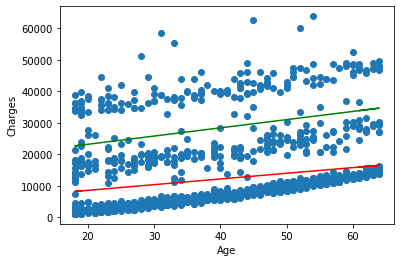

In [31]:
# Arbitrary lines that separate the three clusters.
y1 = 5000 + 180 * insurance["age"]
y2 = 18000 + 260 * insurance["age"]

# The same scatterplot as above, plus y1 and y2.
plt.figure(facecolor = "white")
plt.scatter(insurance["age"], insurance["charges"])
plt.xlabel("Age")
plt.ylabel("Charges")
plt.plot(insurance["age"], y1, color = "red")
plt.plot(insurance["age"], y2, color = "green");

*`Figure 10. Three distinct sets of data points concentrate in the 'low', 'medium', and 'high' charge clusters.`*

`Figure 10` shows the data points along with two straight lines that separate them into 'low', 'medium', and 'high' charge clusters. (In some cases, it's difficult to tell which cluster a data point belongs to; the lines have been chosen somewhat arbitrarily to separate the bulk of each cluster from the rest.) Separating the data as in `Figure 10` and running linear regression on the resulting clusters reveals, expectectly, a much stronger linear correlation in all three cases.

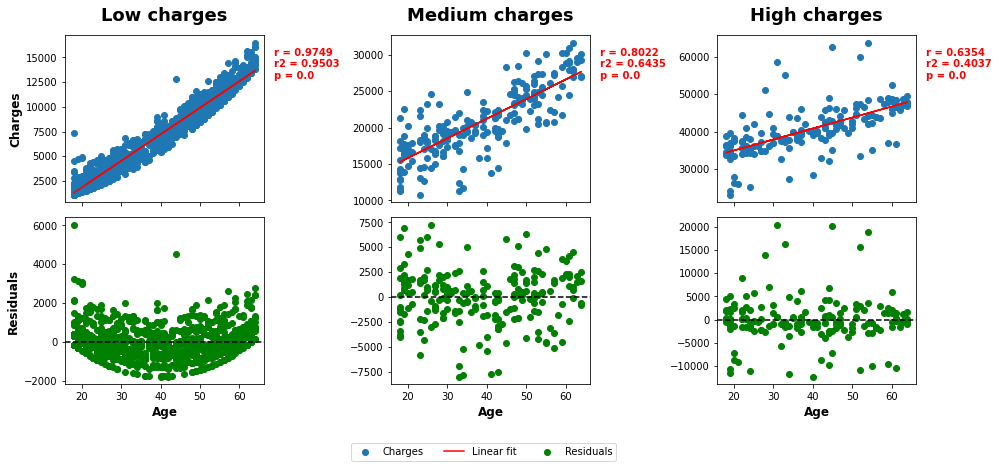

In [32]:
# Split the data into the three clusters seen in the scatterplot above.
age_charge_low = insurance.loc[insurance["charges"] <= y1, ["charges", "age"]]
age_charge_medium = insurance.loc[(insurance["charges"] > y1) & (insurance["charges"] <= y2) , ["charges", "age"]]
age_charge_high = insurance.loc[insurance["charges"] > y2, ["charges", "age"]]

fig_clusters, ((ax_c1, ax_c2, ax_c3), (ax_c1_res, ax_c2_res, ax_c3_res)) = plt.subplots(2, 3, figsize = (14, 6), sharex = True, facecolor = "white")

axes = {"data": [ax_c1, ax_c2, ax_c3],
        "residuals": [ax_c1_res, ax_c2_res, ax_c3_res]}

clusters = [age_charge_low, age_charge_medium, age_charge_high]

# Plot data, linear fit, and residuals for all three clusters.
for i in range(3):
    # Axes and data
    data_ax = axes["data"][i]
    residual_ax = axes["residuals"][i]
    data = clusters[i]
    
    # Regression and residuals
    regression = stats.linregress(data["age"], data["charges"])
    fit = regression.intercept + regression.slope * data["age"]
    residuals = data["charges"] - fit    
    
    # r, r2 and p
    r = round(regression.rvalue, 4)
    r2 = round(regression.rvalue ** 2, 4)
    p = round(regression.pvalue, 4)
    
    # Plot data and regression
    format_axes(data_ax)
    data_ax.scatter("age", "charges", data = data, label = "Charges")
    data_ax.plot(data["age"], fit, color = "red", label = "Linear fit")
         
    data_ax.annotate("r = {}\nr2 = {}\np = {}".format(r, r2, p), (1.05, 0.74), xycoords = "axes fraction", color = "red", fontsize = "medium", fontweight = "bold")
    
    # Plot residuals
    format_axes(residual_ax)
    residual_ax.scatter(data["age"], residuals, color = "green", label = "Residuals")
    residual_ax.axhline(0, ls = "--", color = "black")

# Format the charts' titles, axes, and legend.
ax_c1.set_title("Low charges", fontweight = "bold", fontsize = 18, y = 1.05)
ax_c2.set_title("Medium charges", fontweight = "bold", fontsize = 18, y = 1.05)
ax_c3.set_title("High charges", fontweight = "bold", fontsize = 18, y = 1.05)

ax_c1.set_ylabel("Charges")
ax_c1_res.set_ylabel("Residuals")

for ax in axes["residuals"]:
    ax.set_xlabel("Age")

handles, labels = ax_c1.get_legend_handles_labels()
res_handles, res_labels = ax_c1_res.get_legend_handles_labels()

handles.append(res_handles[0])
labels.append(res_labels[0])
    
fig_clusters.legend(handles = handles, labels = labels, bbox_to_anchor= (0.62, -0.02), ncol = 3)
fig_clusters.tight_layout();

*`Figure 11. Scatterplot, linear fit, and residuals for the low-, medium-, and high-charge data clusters.`*

All three clusters display moderate-to-excellent linear correlation, and in all three cases, the p-value is zero. This means that **the slope of the data trendline at the population level is almost surely not zero, i.e. age *does* correlate with the magnitude of medical expenses.**

Given the average distance of the medium- and high-charge cluster from the low-charge data cluster, it's probable they represent exceptions; medical expenses that are unusually or even very unusually high for each age. This is also corroborated by the fact the data density for medium and high charges is visibly lower compared to low charges.

High charges have the weakest correlation of all three, with only about 40% of the variation in the data explained by the linear model. There are a few high-leverage points that are likely to influence the slope of the high-charge fitted line (especially on the top-right corner of the chart), though the central cloud follows a fairly clear linear trajectory. 

Medium charges have a much stronger correlation, with over 64% of the data variability explained by the linear fit. The linear fit of low charges is nearly perfect, with about 95% of data variability explained by the model; however, unlike the other two cases, the data follows very clearly a curved trajectory, which is also visible in the residuals chart. This suggests that, despite the near-perfect fit, a different model may fit the data better.

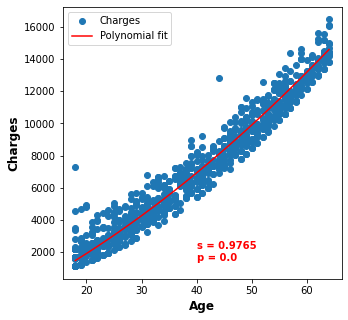

In [33]:
# On the assumption the observed relation is not linear, let's compute Spearman's correlation coefficient instead.
spearman = stats.spearmanr(age_charge_low["age"], age_charge_low["charges"])
s = round(spearman.correlation, 4)
p = round(spearman.pvalue, 4)

from scipy import odr

# Let's try to fit a second-order polynomial.
poly_model = odr.polynomial(2)
data = odr.Data(age_charge_low["age"], age_charge_low["charges"])
odr_obj = odr.ODR(data, poly_model)
output = odr_obj.run()

# Second order polynomial equation predicting the charges.
poly = np.poly1d(output.beta[::-1])

# Predicted charges (polynomial fitted to the data).
poly_y = poly(age_charge_low["age"])

fig_age_charge_poly, ax_age_charge_poly = plt.subplots(1, 1, figsize = (5, 5), facecolor ="white")

# Plot the data and the fitted polynomial.
format_axes(ax_age_charge_poly)
ax_age_charge_poly.scatter(age_charge_low["age"], age_charge_low["charges"], label="Charges")

# Sorted ages and charges, needed for correct visualisation.
sorted_ages = age_charge_low["age"].sort_values()
sorted_charges = sorted(poly_y)
ax_age_charge_poly.plot(sorted_ages, sorted_charges, label="Polynomial fit", color = "red")
ax_age_charge_poly.set_ylabel("Charges")
ax_age_charge_poly.set_xlabel("Age")

ax_age_charge_poly.annotate("s = {}\np = {}".format(s, p), (40, 1500), color = "red", fontweight = "bold")
ax_age_charge_poly.legend();

*`Figure 12. The low-charge cluster with a curved model fitted to it. This fit is only very marginally better.`*

Visually, a curve fits the data slightly better; Spearman's correlation coefficient (which measures non-linear, monotonic correlations between variables), is also a little 
bit higher than Pearson's *r* (0.9765 vs 0.9749). The difference is minimal, but it does suggest that the observed relation is not perfectly linear although very close to it. The p-value of zero confirms that, had there been no correlation between age and medical expenditures in the population, there would be virtually no possibility of observing a dataset with such a strong correlation between the two just out of random chance.

In conclusion, the data definitely support the claim that medical expenses go up with age, which is unfortunately very intuitive. (Had the dataset contained data about people older than 65, we would probably see charges grow even faster.)

## Conclusions

In this project, I used a simulated dataset of yearly medical insurance costs for American insurance contractors. The goal of the project was to test four hypotheses:

1. Average medical expenses are the same for male and female patients.
2. Average medical expenses are higher for people with higher BMI. (Body mass index; see below for more information.)
3. Smokers have higher average expenses than non-smokers.
4. Medical expenses grow with age.

The results of the analyses have shown that, in fact, **average medical expenses are _not_ the same for male and female patients;** on average, they are 1387 dollars higher for males. This difference is statistically significant at a 0.05 significance level. (If there was no difference between the average expenditures of male and female patients in the population, there would be less than a 5% probability of observing a sample with a difference of $1387 out of random chance.)

**Average medical expenses _are_ higher for people with higher BMI in the sample,** but depending on the BMI, the existence of this difference in the population may or may not be supported by the data. In particular, the difference in expenditures between normal-weight and overweight people is not significant, with over 37% chance of selecting a sample displaying at least the observed difference of -537 dollars even if there was no difference at the population level. By contrast, **the difference between the average expenditures of normal-weight and obese people (-5143 USD) is very statistically significant,** with virtually no chance of observing such a sample if there was no difference between their expenditures at the population level.

The analysis also confirmed that **medical expenditures for smokers are *much* higher than for non-smokers,** with a difference of well over 20.000 USD per year, and again no chance of observing such difference in a sample from a population where the difference was zero. 

Finally, **the data displays an increasing linear correlation between a patient's age and their yearly medical expenditures.** Three clusters of low-, medium-, and high-charges have been identified, roughly with ranges 0-16000, 16000-30000, and 30000+ USD, in all of which the magnitude of expenditures correlates linearly with age. The observed correlation was nearly perfect for the low-charge cluster, strong for the medium-charge cluster, and moderate for the high-expenditure cluster. This, coupled with the fact that most observations fell into the low-charge cluster, suggests that **low expenditures are more common and follow a stronger, linear trend than the other two clusters, which represents increasingly uncommon expenditures with a more unpredictable pattern.**